<a href="https://colab.research.google.com/github/yannuma/PrivacyProject/blob/main/Model_Creation/Main_PrivacyProject_Opacus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with and without Differential Privacy Mechanism (using Opacus)
---

Main file to apply and compare differential privacy in the training of neural networks. To apply differential privacy in NN training we use the Python library Opacus.


In [1]:
# install and import necessary libraries
!pip install opacus
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator
import tarfile
import torch
import requests
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torchvision
import torch.utils.data as torch_data
import torchvision.transforms as transforms
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time
from google.colab import files


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 2.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
#Download the dataset and save features and labels in two different lists
response = requests.get(f'https://www.comp.nus.edu.sg/~reza/files/dataset_texas.tgz')
if response.status_code == 200:
    with open(f'dataset_texas.tgz', 'wb') as file:
        file.write(response.content)
    print("Download completed successfully.")
else:
    print(f"Failed to download file: {response.status_code}")

with tarfile.open(f'dataset_texas.tgz') as f:
    f.extractall(f'data/')

with open('data/texas/100/feats', 'r') as f:
    features = f.readlines()
with open('data/texas/100/labels', 'r') as f:
    labels = f.readlines()

print(len(features))
print(len(labels))

Download completed successfully.
67330
67330


In [ ]:
'''
Classical Network Architecture:
3 Linear Layers
This neural network consists of three linear layers.
The first and second layers use the Tanh activation function, while the third layer outputs the final predictions.
Input size is 6169, and it outputs 101 classes with one hidden layers of size 128.
Tanh activation function (somehow) works better than classic activation function like Relu for DPSG.
'''
class NetSeq(nn.Module):
    def __init__(self):
        super(NetSeq, self).__init__()
        self.fc1 = nn.Linear(6169, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 101)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

'''
Function to calculate the acuracy of a network for a given dataset.
Device decides if the calculations happens on CPU or GPU.
'''
def calc_accuracy(loader, network, device):
    correct = 0
    total = 0
    for data in loader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = network(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    return (correct / total, total)

In [ ]:
"""
Classical train algorithm for neural networks.
trainloader: loader for the train data
testoader: data to calculate the accuracy of the model
lr: learning rate (stepsize of SGD)
epochs: number of iterations
network_output: boolean, if True it return the model otherwise the max accuracy
"""
def train_nn(trainloader, testloader, lr, epochs, network_output):
		losses = []
		train_accs = []
		test_accs = []
		max_accuracy = 0
		best_model_path = 'best_model.pth'

		device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
		network = NetSeq().to(device)
		optimizer = torch.optim.Adam(network.parameters(), lr = lr)
		criterion = nn.CrossEntropyLoss()

		#print('Start training on', device)
		for epoch in range(epochs):

			#print('Epoch: {}'.format(epoch + 1))
			epoch_loss = []

			for i, data in enumerate(trainloader, 0):
				inputs, labels = data
				inputs, labels = inputs.to(device), labels.to(device)
				optimizer.zero_grad()
				outputs = network(inputs)
				loss = criterion(outputs, labels)
				epoch_loss.append(loss.item())
				loss.backward()
				optimizer.step()

			losses.append(np.mean(epoch_loss))

			# Compute accuracy on training data
			with torch.no_grad():
				acc_tuple = calc_accuracy(trainloader, network, device)

			#print('Accuracy of the network on %d train inputs: %d %%' % (acc_tuple[1], 100 * acc_tuple[0]))
			train_accs.append(acc_tuple[0])

			# Validate all classes
			with torch.no_grad():
				acc_tuple = calc_accuracy(testloader, network, device)

			#print('Accuracy of the network on %d test inputs: %d %%' % (acc_tuple[1], 100 * acc_tuple[0]))
			test_accs.append(acc_tuple[0])
			if acc_tuple[0] > max_accuracy:
				max_accuracy = acc_tuple[0]
				if network_output:
					torch.save(network.state_dict(), best_model_path)

		if network_output:
			network.load_state_dict(torch.load(best_model_path))
			network.to('cpu')
			return network
		else:
			#print('Final accuracy: ', max_accuracy)
			return max_accuracy

"""
Classical train algorithm for neural networks but with Differential Privat SGD.
trainloader: loader for the train data
testoader: data to calculate the accuracy of the model
lr: learning rate (stepsize of SGD)
epochs: number of iterations
network_output: boolean, if True it return the model otherwise the max accuracy
C: Clipping Treshhold
epsilon: the privacy budget
"""
def train_nn_DP(trainloader, testloader, lr, epochs, network_output, C, epsilon):
		losses = []
		train_accs = []
		test_accs = []
		max_accuracy = 0
		best_model_path = 'best_model.pth'
		Delta = 1e-5

		device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

		network = NetSeq().to(device)
		network = ModuleValidator.fix(network)
		network = network.to(device)
		optimizer = torch.optim.Adam(network.parameters(), lr = lr)
		criterion = nn.CrossEntropyLoss()

		#define privacy engine
		privacy_engine = PrivacyEngine()
		#receive "private" network, optimizer and trainloader for given Delta, Epsilon and C
		network, optimizer, trainloader = privacy_engine.make_private_with_epsilon(
    	module=network,
    	optimizer=optimizer,
    	data_loader=trainloader,
    	max_grad_norm=C,
			target_epsilon = epsilon,
			target_delta = Delta,
			epochs = epochs
			)

		network.to(device)

		#print('Start training on', device)
		for epoch in range(epochs):

			#print('Epoch: {}'.format(epoch + 1))

			epoch_loss = []

			for i, data in enumerate(trainloader, 0):
				inputs, labels = data
				inputs, labels = inputs.to(device), labels.to(device)
				optimizer.zero_grad()
				outputs = network(inputs)
				loss = criterion(outputs, labels)
				epoch_loss.append(loss.item())
				loss.backward()
				optimizer.step()

			losses.append(np.mean(epoch_loss))

			# Compute accuracy on training data
			with torch.no_grad():
				acc_tuple = calc_accuracy(trainloader, network, device)

			#print('Accuracy of the network on %d train inputs: %d %%' % (acc_tuple[1], 100 * acc_tuple[0]))
			train_accs.append(acc_tuple[0])

			# Validate all classes
			with torch.no_grad():
				acc_tuple = calc_accuracy(testloader, network, device)

			#print('Accuracy of the network on %d test inputs: %d %%' % (acc_tuple[1], 100 * acc_tuple[0]))
			test_accs.append(acc_tuple[0])
			if acc_tuple[0] > max_accuracy:
				max_accuracy = acc_tuple[0]
				if network_output:
					torch.save(network.state_dict(), best_model_path)

		epsilon = privacy_engine.get_epsilon(delta=Delta)
		#print("Our Privacy Budget is:", epsilon)

		if network_output:
			network.load_state_dict(torch.load(best_model_path))
			network.to('cpu')
			return network
		else:
			#print('Final accuracy: ', max_accuracy)
			return max_accuracy

In [ ]:
#Process the Data such that we can create a torch dataset
features_list = [list(map(int, ''.join(feature.split()).split(','))) for feature in features]
labels_list = [int(label.strip()) for label in labels]
size = int(0.8 * len(features))
feat_tens_train = torch.tensor(features_list[:size], dtype=torch.float)
l_tens_train = torch.tensor(labels_list[:size], dtype=torch.long)
feat_tens_test = torch.tensor(features_list[size:], dtype=torch.float)
l_tens_test = torch.tensor(labels_list[size:], dtype=torch.long)
dataset_train = TensorDataset(feat_tens_train, l_tens_train)
dataset_test = TensorDataset(feat_tens_test, l_tens_test)


# Hyperparameter Optimization for training the NN without Privacy

In [ ]:
#find parameters for the best model
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]
epoch_numbers = [5, 10, 20]
results = []

for lr, batch, epochs in itertools.product(learning_rates, batch_sizes, epoch_numbers):
    #print(f"Training with lr={lr}, batch size={batch}, epochs={epochs}")
    trainloader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
    testloader = DataLoader(dataset_test, batch_size=batch, shuffle=True)

    accuracy = train_nn(trainloader, testloader, lr, epochs, False)
    results.append((lr, batch, epochs, accuracy))

# Find the best parameters based on accuracy
best_params = max(results, key=lambda x: x[3])
print(f"Best parameters found: lr={best_params[0]}, batch size={best_params[1]}, epochs={best_params[2]} with accuracy={best_params[3]}")

df_results = pd.DataFrame(results, columns=['learning_rate', 'batch_size', 'epochs', 'accuracy'])
df_results

Best parameters found: lr=0.001, batch size=64, epochs=10 with accuracy=0.628694489826229


,learning_rate,batch_size,epochs,accuracy
0,0.001,16,5,0.620600
1,0.001,16,10,0.626021
2,0.001,16,20,0.622531
3,0.001,32,5,0.623719
4,0.001,32,10,0.621640
5,0.001,32,20,0.624981
6,0.001,64,5,0.621862
7,0.001,64,10,0.628694
8,0.001,64,20,0.622754
9,0.010,16,5,0.544557


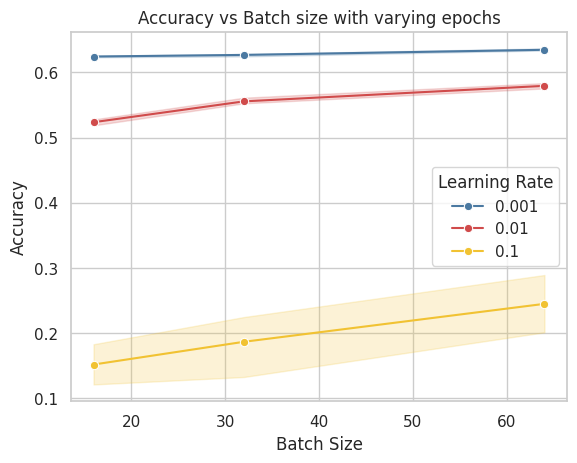

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

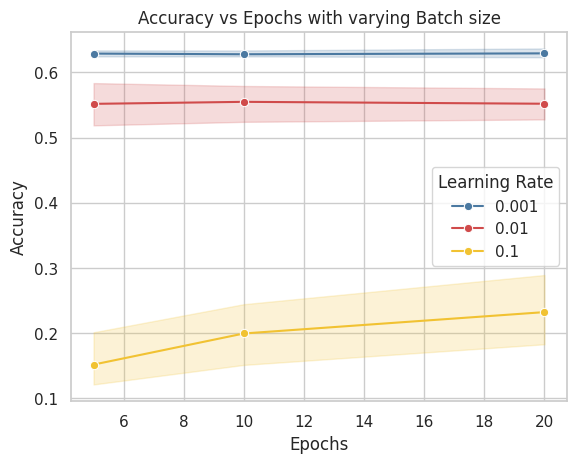

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
#df_results.to_csv('df_results.csv', index=False)
#files.download('df_results.csv')
url = "https://raw.githubusercontent.com/yannuma/PrivacyProject/main/Model_Creation/Dataframes_results/df_results.csv"
df_results = pd.read_csv(url)

#plot some results
sns.lineplot(data=df_results, x='batch_size', y='accuracy', hue='learning_rate', dashes=True, palette=['#4b79a1', '#d04b4b', '#f1c232'], marker='o')
plt.title('Accuracy vs Batch size with varying epochs')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.savefig('HypPa_BatchSize.png')
plt.show()
files.download('HypPa_BatchSize.png')

sns.lineplot(data=df_results, x='epochs', y='accuracy', hue='learning_rate', dashes=False, palette=['#4b79a1', '#d04b4b', '#f1c232'], marker='o')
plt.title('Accuracy vs Epochs with varying Batch size')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.savefig('HypPa_Epochs.png')
plt.show()
files.download('HypPa_Epochs.png')

In [ ]:
#train best Model from the information above and download it
lr = best_params[0]
epochs = best_params[2]
batch = best_params[1]

trainloader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
testloader = DataLoader(dataset_test, batch_size=batch, shuffle=True)

model = train_nn(trainloader, testloader, lr, epochs, True)
torch.save(model.state_dict(), 'model.pth')
files.download('model.pth')

#Hyperparameter Optimization for training the NN with Privacy (Opacus)

In [ ]:
## Differential Privacy ##

#find the optimal clipping parameter C
lr = 0.001
batch = 64
epochs = 10
epsilon = 20

trainloader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
testloader = DataLoader(dataset_test, batch_size=batch, shuffle=True)

acc_list = []
runs = 3
for C in range(1, 10):
  #print("Start training for C = ", C )
  accuracy = 0
  for _ in range(runs):
    accuracy += train_nn_DP(trainloader, testloader, lr, epochs, False, C, epsilon)/runs
  acc_list.append(accuracy)

/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


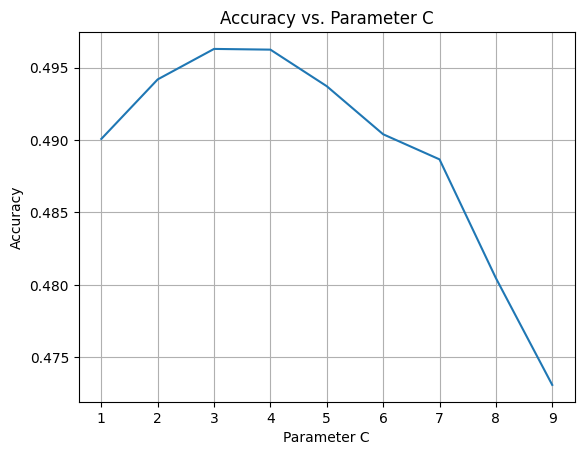

In [ ]:
#Plot
print()
c = list(range(1, 10))
sns.lineplot(x=c, y=acc_list)
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Parameter C')
plt.grid(True)
plt.show()

In [ ]:
#Best Value for the parameter C is 3
C = 3
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]
epoch_numbers = [10, 20]

epsilon = 20
results20 = []
for lr, batch, epochs in itertools.product(learning_rates, batch_sizes, epoch_numbers):
    #print(f"Training with lr={lr}, batch size={batch}, epochs={epochs}")
    trainloader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
    testloader = DataLoader(dataset_test, batch_size=batch, shuffle=True)

    accuracy = train_nn_DP(trainloader, testloader, lr, epochs, False, C, epsilon)
    results20.append((lr, batch, epochs, epsilon, accuracy))

# Find the best parameters based on accuracy
best_params = max(results20, key=lambda x: x[4])
print(f"Best parameters found: lr={best_params[0]}, batch size={best_params[1]}, epochs={best_params[2]} with accuracy={best_params[4]}")

epsilon = 10
results10 = []
for lr, batch, epochs in itertools.product(learning_rates, batch_sizes, epoch_numbers):
    #print(f"Training with lr={lr}, batch size={batch}, epochs={epochs}")
    trainloader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
    testloader = DataLoader(dataset_test, batch_size=batch, shuffle=True)

    accuracy = train_nn_DP(trainloader, testloader, lr, epochs, False, C, epsilon)
    results10.append((lr, batch, epochs, epsilon, accuracy))

# Find the best parameters based on accuracy
best_params = max(results10, key=lambda x: x[4])
print(f"Best parameters found: lr={best_params[0]}, batch size={best_params[1]}, epochs={best_params[2]} with accuracy={best_params[4]}")

epsilon = 1
results1 = []
for lr, batch, epochs in itertools.product(learning_rates, batch_sizes, epoch_numbers):
    #print(f"Training with lr={lr}, batch size={batch}, epochs={epochs}")
    trainloader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
    testloader = DataLoader(dataset_test, batch_size=batch, shuffle=True)

    accuracy = train_nn_DP(trainloader, testloader, lr, epochs, False, C, epsilon)
    results1.append((lr, batch, epochs, epsilon, accuracy))

# Find the best parameters based on accuracy
best_params = max(results1, key=lambda x: x[4])
print(f"Best parameters found: lr={best_params[0]}, batch size={best_params[1]}, epochs={best_params[2]} with accuracy={best_params[4]}")

results_combined = results1 + results10 + results20
df_combined = pd.DataFrame(results_combined, columns=['learning_rate', 'batch_size', 'epochs', 'epsilon', 'accuracy'])
df_combined

/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Best parameters found: lr=0.001, batch size=128, epochs=20 with accuracy=0.4887865735927521
Best parameters found: lr=0.001, batch size=128, epochs=20 with accuracy=0.47022129808406354
Best parameters found: lr=0.001, batch size=64, epochs=20 with accuracy=0.3777662260507946


,learning_rate,batch_size,epochs,epsilon,accuracy
0,0.001,32,10,1,0.321402
1,0.001,32,20,1,0.353928
2,0.001,64,10,1,0.306030
3,0.001,64,20,1,0.377766
4,0.001,128,10,1,0.288801
5,0.001,128,20,1,0.369598
6,0.010,32,10,1,0.094460
7,0.010,32,20,1,0.070845
8,0.010,64,10,1,0.156617
9,0.010,64,20,1,0.148671


In [ ]:
#train now the bests privat models and download them
lr = 0.001
batch = 128
epochs = 20
C = 3
trainloader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
testloader = DataLoader(dataset_test, batch_size=batch, shuffle=True)
model_E = train_nn_DP(trainloader, testloader, lr, epochs, True, 3, 20)

torch.save(model_E._module.state_dict(), 'model_E.pth')
files.download('model_E.pth')

model_X = train_nn_DP(trainloader, testloader, lr, epochs, True, 3, 10)

torch.save(model_X._module.state_dict(), 'model_X.pth')
files.download('model_X.pth')

batch = 64
trainloader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
testloader = DataLoader(dataset_test, batch_size=batch, shuffle=True)
model_Y = train_nn_DP(trainloader, testloader, lr, epochs, True, 3, 1)

torch.save(model_Y._module.state_dict(), 'model_Y.pth')
files.download('model_Y.pth')

/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

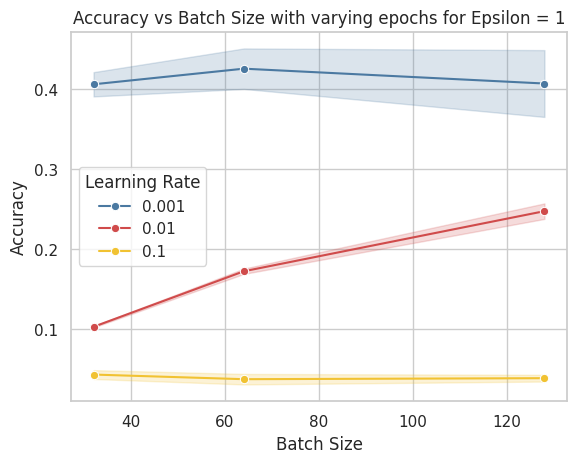

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

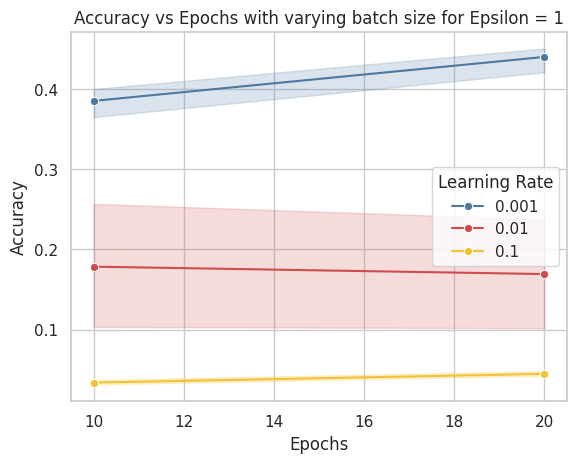

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

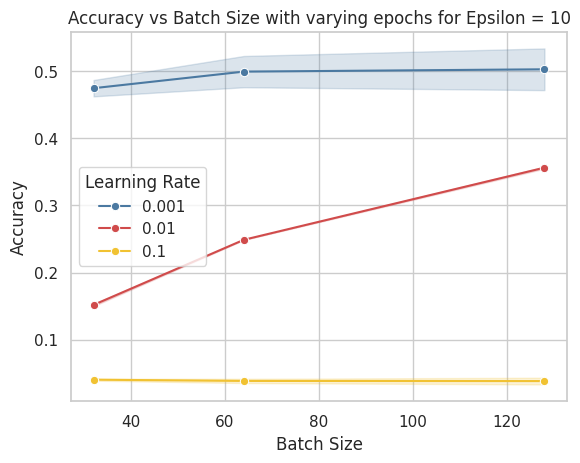

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

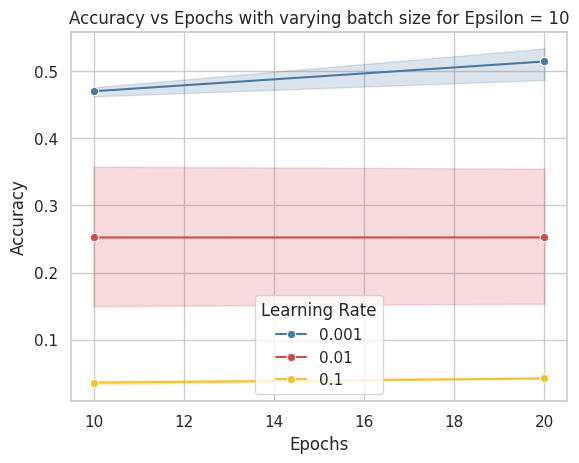

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

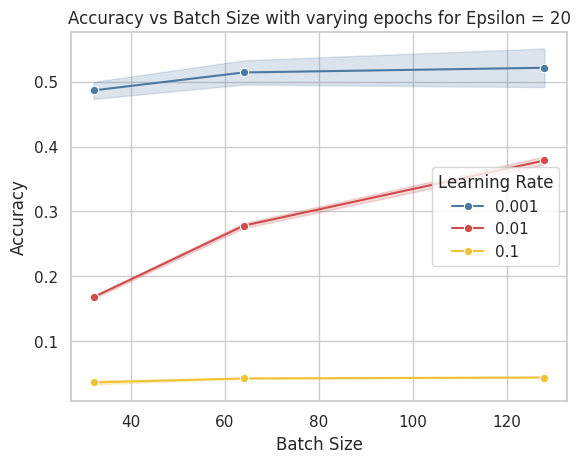

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

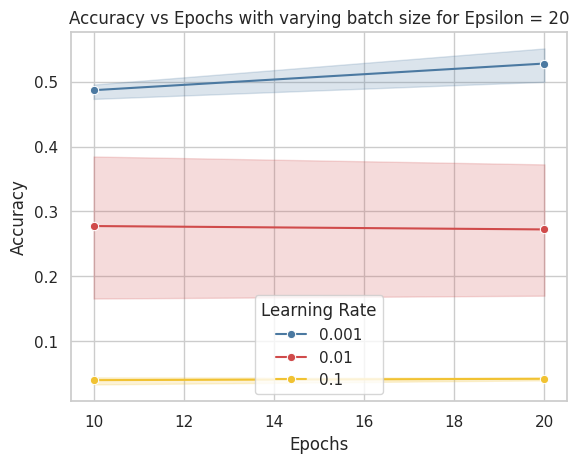

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
#df_combined.to_csv('df_combined.csv', index=False)
#files.download('df_combined.csv')
url = "https://raw.githubusercontent.com/yannuma/PrivacyProject/main/Model_Creation/Dataframes_results/df_combined.csv"
df_combined = pd.read_csv(url)


sns.lineplot(data=df_combined[df_combined['epsilon']==1], x='batch_size', y='accuracy', hue='learning_rate', dashes=True, palette=['#4b79a1', '#d04b4b', '#f1c232'], marker='o')
plt.title('Accuracy vs Batch Size with varying epochs for Epsilon = 1')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.savefig('HypPa_BatchS_eps1.png')
plt.show()
files.download('HypPa_BatchS_eps1.png')


sns.lineplot(data=df_combined[df_combined['epsilon']==1], x='epochs', y='accuracy', hue='learning_rate', dashes=False, palette=['#4b79a1', '#d04b4b', '#f1c232'], marker='o')
plt.title('Accuracy vs Epochs with varying batch size for Epsilon = 1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.savefig('HypPa_Epochs_eps1.png')
plt.show()
files.download('HypPa_Epochs_eps1.png')


sns.lineplot(data=df_combined[df_combined['epsilon']==10], x='batch_size', y='accuracy', hue='learning_rate', dashes=True, palette=['#4b79a1', '#d04b4b', '#f1c232'], marker='o')
plt.title('Accuracy vs Batch Size with varying epochs for Epsilon = 10')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.savefig('HypPa_BatchS_eps10.png')
plt.show()
files.download('HypPa_BatchS_eps10.png')

sns.lineplot(data=df_combined[df_combined['epsilon']==10], x='epochs', y='accuracy', hue='learning_rate', dashes=False, palette=['#4b79a1', '#d04b4b', '#f1c232'], marker='o')
plt.title('Accuracy vs Epochs with varying batch size for Epsilon = 10')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.savefig('HypPa_Epochs_eps10.png')
plt.show()
files.download('HypPa_Epochs_eps10.png')


sns.lineplot(data=df_combined[df_combined['epsilon']==20], x='batch_size', y='accuracy', hue='learning_rate', dashes=True, palette=['#4b79a1', '#d04b4b', '#f1c232'], marker='o')
plt.title('Accuracy vs Batch Size with varying epochs for Epsilon = 20')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.savefig('HypPa_BatchS_eps20.png')
plt.show()
files.download('HypPa_BatchS_eps20.png')

sns.lineplot(data=df_combined[df_combined['epsilon']==20], x='epochs', y='accuracy', hue='learning_rate', dashes=False, palette=['#4b79a1', '#d04b4b', '#f1c232'], marker='o')
plt.title('Accuracy vs Epochs with varying batch size for Epsilon = 20')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.savefig('HypPa_Epochs_eps20.png')
plt.show()
files.download('HypPa_Epochs_eps20.png')


In [13]:
#Create a Table
data = {
    "Model": ["NN", "Opacus NN DP", "Opacus NN DP", "Opacus NN DP", "Pyvacy NN DP", "Pyvacy NN DP", "Pyvacy NN DP"],
    "Accuracy": ["0.63","0.55" ,"0.53","0.45", "0.37", "0.38", "0.26"],
    "Epsilon": ["-", "20", "10", "1", "28", "12", "1.3"],
    "Epochs": [ "10", "20", "20", "20", "20", "20", "20"]
  }
df = pd.DataFrame(data)
df

,Model,Accuracy,Epsilon,Epochs
0,NN,0.63,-,10
1,Opacus NN DP,0.55,20,20
2,Opacus NN DP,0.53,10,20
3,Opacus NN DP,0.45,1,20
4,Pyvacy NN DP,0.37,28,20
5,Pyvacy NN DP,0.38,12,20
6,Pyvacy NN DP,0.26,1.3,20


# Final Analysis of the models

Now lr, batchsize clipping parameter C is fixed for all models.

In [ ]:
lr = 0.001
batch = 64
epochs = [5, 10, 20]
eps = [1, 10, 20]
C = 3
n = 3
trainloader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
testloader = DataLoader(dataset_test, batch_size=batch, shuffle=True)

analyse = []

for epoch in epochs:
    for _ in range(n):
        start_time = time.time()
        accuracy = train_nn(trainloader, testloader, lr, epoch, False)
        end_time = time.time()
        analyse.append((epoch, 0 ,accuracy, end_time - start_time))

for epoch in epochs:
    for ep in eps:
        for _ in range(n):
            start_time = time.time()
            accuracy = train_nn_DP(trainloader, testloader, lr, epoch, False, C, ep)
            end_time = time.time()
            analyse.append((epoch, ep, accuracy, end_time - start_time))

df_analyse = pd.DataFrame(analyse, columns=['epochs', 'epsilon', 'accuracy', 'time'])
#df_analyse.to_csv('df_analyse.csv', index=False)
#files.download('df_analyse.csv')

/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


# Plotting the final results

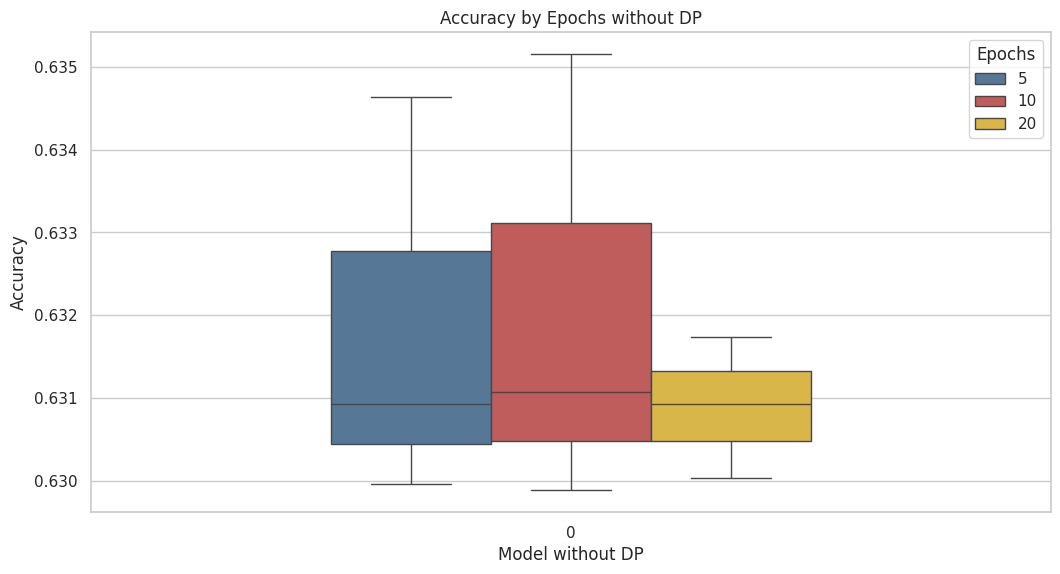

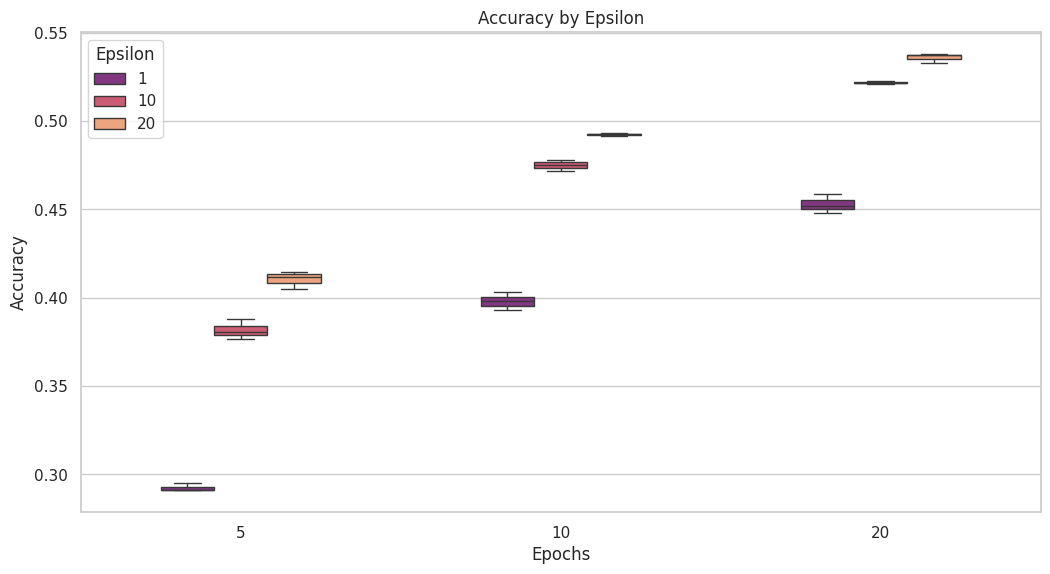

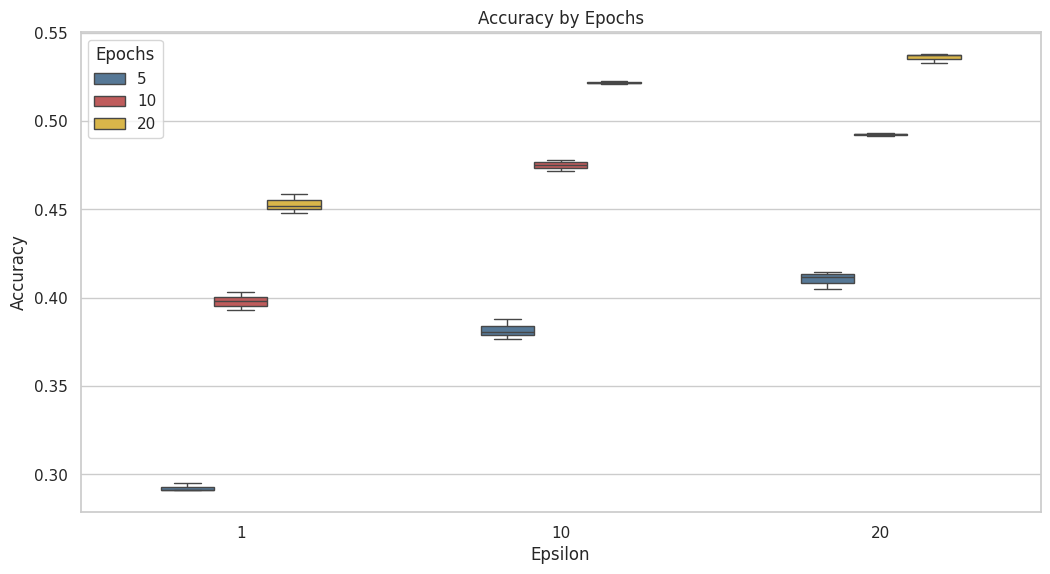

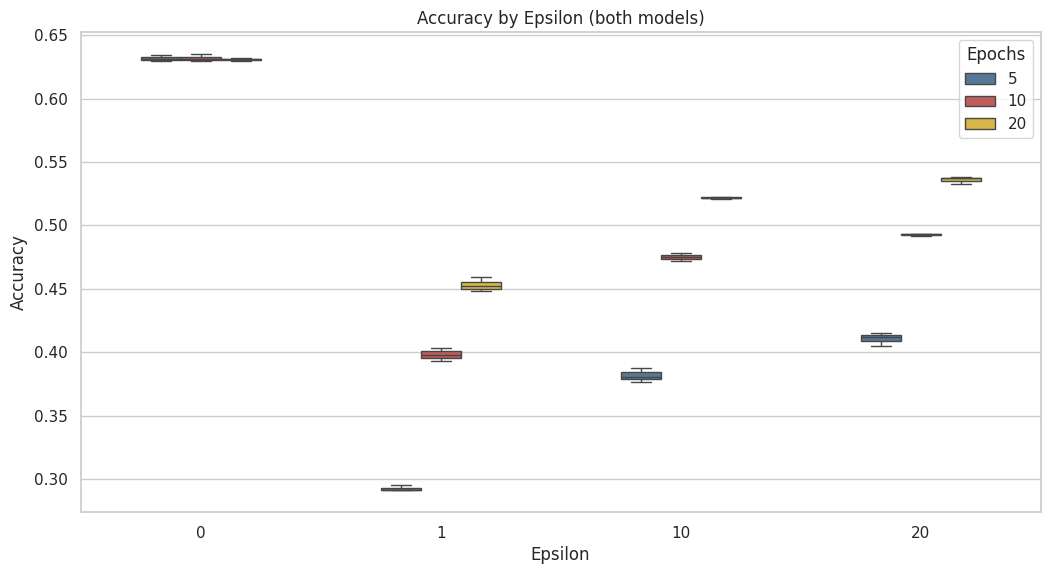

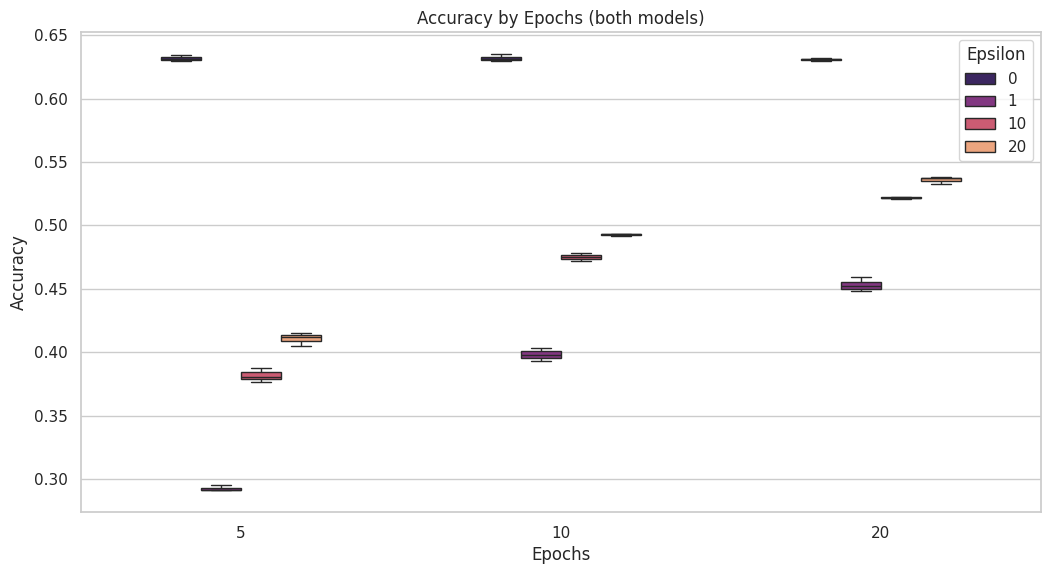

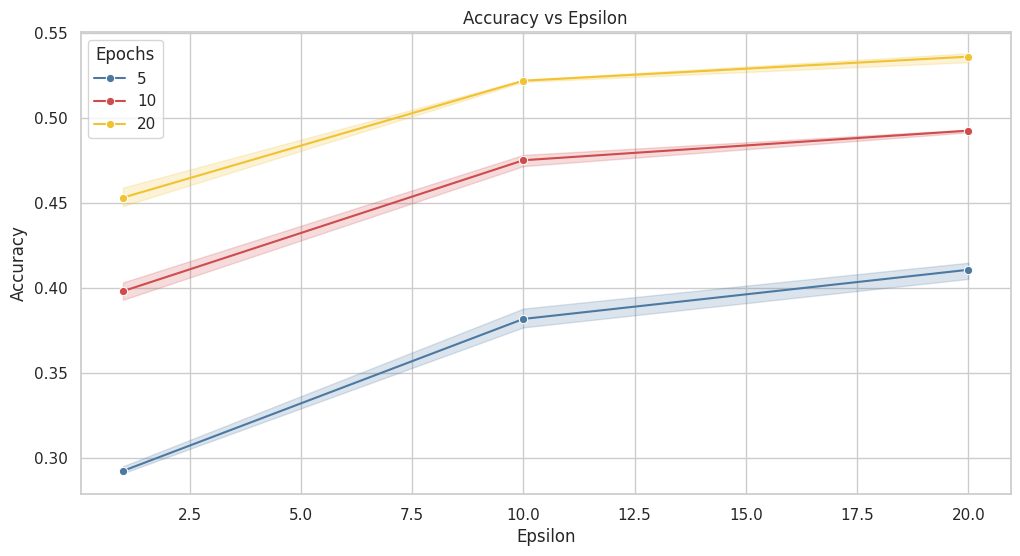

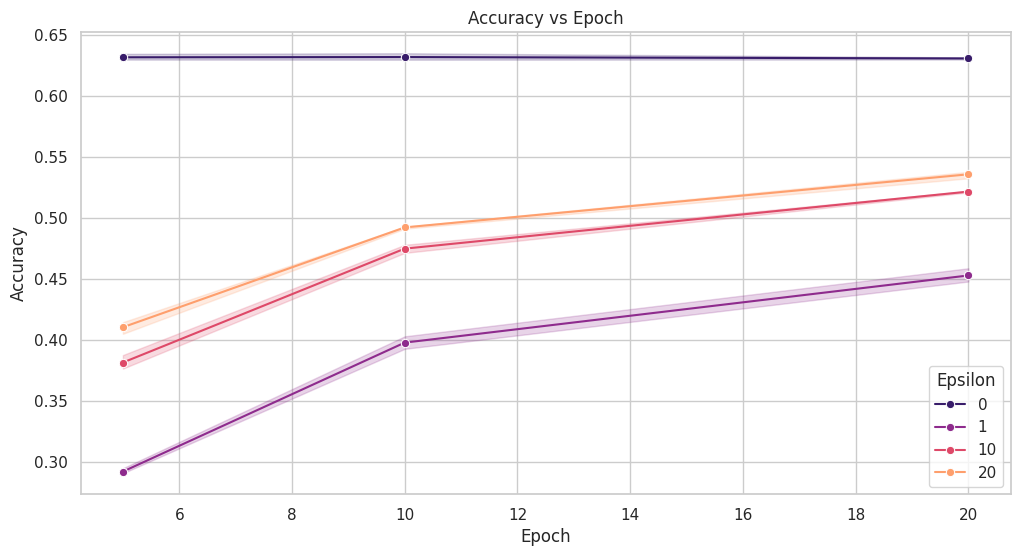

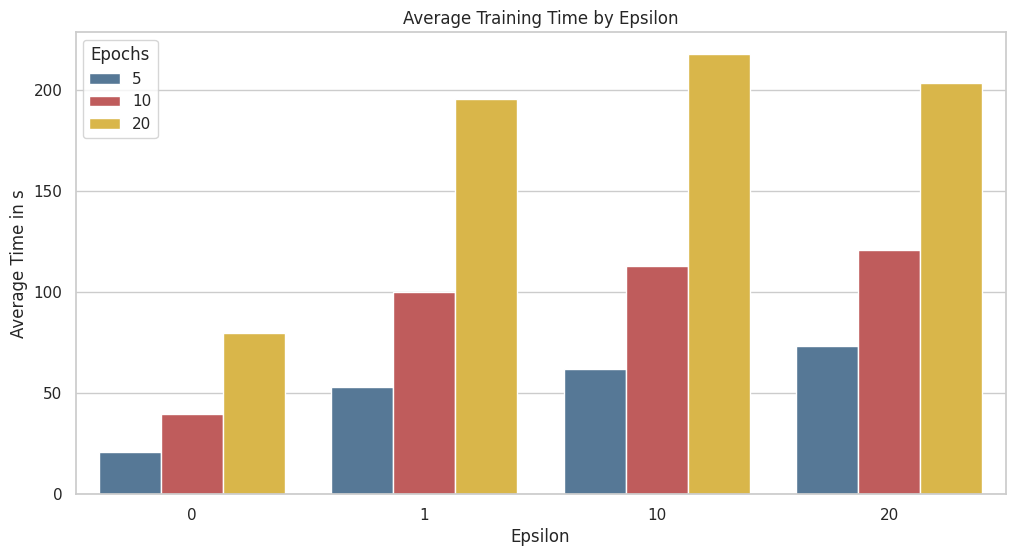

In [3]:
url = "https://raw.githubusercontent.com/yannuma/PrivacyProject/main/Model_Creation/Dataframes_results/df_analyse.csv"
df_analyse = pd.read_csv(url)

epscol = ['#381c6a', '#8e2b8d', '#de4968', '#fe9f6d']
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
box_plot = sns.boxplot(x='epsilon', y='accuracy', hue='epochs', data=df_analyse[df_analyse['epsilon'] == 0], palette=['#4b79a1', '#d04b4b', '#f1c232'], width=0.5)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3)
plt.title('Accuracy by Epochs without DP')
plt.xlabel('Model without DP')
plt.ylabel('Accuracy')
handles, labels = box_plot.get_legend_handles_labels()
box_plot.legend(handles=handles, labels=labels, title='Epochs')
plt.savefig('Fin_box_Epoch.png')
plt.show()
#files.download('Fin_box_Epoch.png')

plt.figure(figsize=(12, 6))
box_plot = sns.boxplot(x='epochs', y='accuracy', hue='epsilon', data=df_analyse[df_analyse['epsilon'] != 0], palette=epscol[1:], width=0.5)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3)
plt.title('Accuracy by Epsilon')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
handles, labels = box_plot.get_legend_handles_labels()
box_plot.legend(handles=handles, labels=labels, title='Epsilon')
plt.savefig('Fin_box_Eps.png')
plt.show()
#files.download('Fin_box_Eps.png')

plt.figure(figsize=(12, 6))
box_plot = sns.boxplot(x='epsilon', y='accuracy', hue='epochs', data=df_analyse[df_analyse['epsilon'] != 0], palette=['#4b79a1', '#d04b4b', '#f1c232'], width=0.5)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3)
plt.title('Accuracy by Epochs')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
handles, labels = box_plot.get_legend_handles_labels()
box_plot.legend(handles=handles, labels=labels, title='Epochs')
plt.savefig('Fin_box_Eps_epoch.png')
plt.show()
#files.download('Fin_box_Eps_epoch.png')

plt.figure(figsize=(12, 6))
box_plot = sns.boxplot(x='epsilon', y='accuracy', hue='epochs', data=df_analyse, palette=['#4b79a1', '#d04b4b', '#f1c232'], width=0.5)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3)
plt.title('Accuracy by Epsilon (both models)')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
handles, labels = box_plot.get_legend_handles_labels()
box_plot.legend(handles=handles, labels=labels, title='Epochs')
plt.savefig('fin_both_box_eps.png')
plt.show()
#files.download('fin_both_box_eps.png')

plt.figure(figsize=(12, 6))
box_plot = sns.boxplot(x='epochs', y='accuracy', hue='epsilon', data=df_analyse, palette=epscol, width=0.5)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3)
plt.title('Accuracy by Epochs (both models)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
handles, labels = box_plot.get_legend_handles_labels()
box_plot.legend(handles=handles, labels=labels, title='Epsilon')
plt.savefig('fin_both_box_epochs.png')
plt.show()
#files.download('fin_both_box_epochs.png')

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
line_plot = sns.lineplot(x='epsilon', y='accuracy', hue='epochs', data=df_analyse[df_analyse['epsilon'] != 0], palette=['#4b79a1', '#d04b4b', '#f1c232'], marker='o')
plt.title('Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.legend(title='Epochs')
plt.savefig('fin_line_plot_eps.png')
plt.show()
#files.download('fin_line_plot_eps.png')

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
line_plot = sns.lineplot(x='epochs', y='accuracy', hue='epsilon', data=df_analyse, palette=epscol, marker='o')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Epsilon')
plt.savefig('fin_line_plot_epochs.png')
plt.show()
#files.download('fin_line_plot_epochs.png')

#Barplot
sns.set(style="whitegrid")
avg_time = df_analyse.groupby(['epsilon', 'epochs'])['time'].mean().unstack()
avg_time_long = avg_time.reset_index().melt(id_vars='epsilon', var_name='epochs', value_name='time')

# Create the bar plot
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='epsilon', y='time', hue='epochs', data=avg_time_long, palette=['#4b79a1', '#d04b4b', '#f1c232'])
plt.title('Average Training Time by Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Average Time in s')
plt.legend(title='Epochs')
plt.savefig('fin_time.png')
plt.show()
#files.download('fin_time.png')